In [141]:
%matplotlib inline
import dlib
import cv2
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io, filters
from skimage.color import rgb2gray
from scipy import ndimage as nd

from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from numpy import argmax
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

import json
from collections import OrderedDict

# create face detector, predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [142]:
def extractLandmark(image) :
    face = detector(image, 1)[0]
    landmarks = predictor(image, face)
    points = landmarks.parts()
    return points

In [143]:
#이미지 불러오기 && 랜드마크 추출
def readImage(imageName) :
    #read image
    image = cv2.imread(imageName) 
    image = cv2.resize(image,(864,1152))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #extract landmark
    points = extractLandmark(image)
    return image, points

In [144]:
def calAngle(points) :
    midx = (points[39].x + points[42].x) / 2
    midy = (points[39].y + points[42].y) / 2
    midx = midx - points[33].x
    midy = midy - points[33].y
    return (90-math.acos(midx*1 / math.sqrt(midx*midx + midy*midy))*180/math.pi)

In [145]:
#origin 점을 기준으로 angle각도 만큼 좌표회전
def rotate(origin, point, angle):
    angle = angle * -1
    ox, oy = origin
    px, py = point
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [146]:
#이미지 및 랜드마크 회전
def rotateImage(image, points, angle) :
    #이미지 회전
    h,w = image.shape[:2]
    rotatedImage = np.copy(image)
    m1 = cv2.getRotationMatrix2D((w/2,h/2), angle,1)
    rotatedImage = cv2.warpAffine(image,m1,(w,h))
    
    #랜드마크 회전
    for p in points :
        p.x, p.y = list(map(int, rotate((w/2,h/2),(p.x,p.y),math.radians(angle))))
    return rotatedImage, points

In [147]:
#이미지 자르기 && 랜드마크도 이동시켜줌
def cutImage(image, points) : 
    ##########중간점 찾기##########
    centerPoint = points[29]
    dx = math.ceil((points[16].x - points[39].x))
    dy = math.ceil((points[8].y - points[29].y))
    ##############자르기#############
    image = image[points[30].y-dy:points[30].y+dy+1,points[33].x-dx:points[33].x+dx+1]

    return image, dx

In [151]:
def sobleFilter(image) :
    image = filters.gaussian(image, sigma=1.5)
    gray_image = rgb2gray(image)
    grad_x = nd.convolve(gray_image, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])) 
    grad_y = nd.convolve(gray_image, np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]))
    mag = np.sqrt(np.power(grad_x,2)+np.power(grad_y,2))
    theta = np.arctan2(np.power(grad_y,2), np.power(grad_x,2))
    return mag, theta

In [159]:
def cal_DD_EOS(image) : 
    mag, theta = sobleFilter(image)
    y_size = image.shape[0]
    x_size = image.shape[1]
    cnt = y_size * x_size / 2
    DD = 0
    for y in range(0,y_size) : 
        for x in range(0,dx) : 
            DD = DD + abs(mag[y][x] - mag[y][x_size-1-x])
    DD = round(DD / cnt,11)

    EOS = 0
    for y in range(0,y_size) : 
        for x in range(0,dx) :
            EOS = EOS + abs(theta[y][x] - theta[y][x_size-1-x])
    EOS = round(math.cos(EOS / cnt),11)
    return DD, EOS

In [161]:
def to_str(points, DD, EOS) :
    st = ''
    st = st+str(DD)+' '+str(EOS)
    for p in points :
            st = st + ' ' + str(p.x) + ' '
            st = st + str(p.y)
    return st

In [ ]:
def write_result_to_Json(result) :
    with open("result.json", "w") as make_file :
    json.dump(result,make_file,ensure_ascii=False, indent = "\t")

In [ ]:
def machineLeaing(Feature) :
    LoadModel = load_model('model.h5')
    predictied = LoadModel.predict(X)
    #점수 및 비대칭 판단
    #결과값 예시
    score = 70
    Symmetry = True
    ASYrate = [10,20,30]
    
    result = OrderedDict()
    result["score"] = score
    result["Symmetry"] = Symmetry
    result["ASYrate"] = ASYrate
    return result

In [148]:
#이미지 출력
def printImage(image, points) :
    for p in points :
        cv2.circle(image, (p.x, p.y), 10, (0, 255, 0), -1)
    plt.imshow(image, cmap='gray')

main

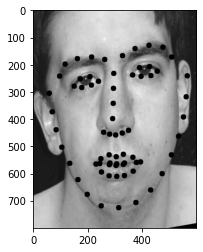

In [164]:
image, points = readImage("0 (14).jpg") #이미지 읽어 오기
angle = calAngle(points) # 회전해야할 각도 계산
image, points = rotateImage(image,points, angle) #이미지 회전
image, dx = cutImage(image, points) #이미지 자르기
image = cv2.resize(image,(600,800)) #다시 resizing
points = extractLandmark(image) #새로운 랜드마크 추출
printImage(image, points)
DD, EOS =  cal_DD_EOS(image) ##DD, EOS 계산
st = to_str(points, DD, EOS) #c++로 보낼 sting 생성
#c++로부터 Feauture 받아옴
result = machineLeaing(Feature)
write_result_to_Json(result)